In [4]:
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
from pathlib import Path
from torch.utils.data import DataLoader

from clex.eval.utils import load_model_for_testing
from clex.eval.Shalem2015.utils import Shalem2015Dataset

In [ ]:
base_path = "/home/workspace/clex/runs/2025-05-06_12-34-12_nanopore_full_debug"

model, _, _, _ = load_model_for_testing(base_path=base_path, skip_data=True)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path

def plot_hexbin_expression_vs_best_track(
    results_dir,                              # e.g. "…/Shalem2015"
    *,                                        # ---- tweakables below ----
    expression_col="expression_value",
    corr_file="track_expression_correlations.csv",
    results_file="all_samples_results.csv",
    use_first_half=True,                      # False -> use second half
    gridsize=60,
    cmap="inferno",
    figsize=(8, 5),
    log_counts=False,
    xlabel="Measured expression level (a.u.)",
    ylabel_template="Predicted RNA-seq coverage ({track})",
    title_template="{track} vs expression  (|r|={rval:.3f})",
    dpi=1200,
    savepath=None,
):
    """
    Hex-bin density plot of expression vs *best*-correlated track.

    Parameters
    ----------
    results_dir : str or Path
        Folder that contains both CSV files produced earlier.
    use_first_half : bool, default True
        If True, consider only tracks with indices < N/2 when picking the best track.
        If False, consider the second half instead.

    Returns
    -------
    fig, ax, best_track
    """
    # -------------------------------------------------- locate / load data ---
    results_dir = Path(results_dir)
    corr_df   = pd.read_csv(results_dir / corr_file)
    results_df = pd.read_csv(results_dir / results_file)

    # numeric track index so we can slice into halves
    corr_df["track_idx"] = corr_df["track"].str.extract(r"(\d+)").astype(int)
    n_tracks  = corr_df["track_idx"].max() + 1
    half_mark = n_tracks // 2

    subset = (corr_df["track_idx"] < half_mark) if use_first_half else (corr_df["track_idx"] >= half_mark)
    best_row = corr_df.loc[subset].iloc[
        corr_df.loc[subset, "correlation_with_expression"].abs().idxmax()
    ]
    best_track = best_row["track"]
    best_r     = best_row["correlation_with_expression"]

    # -------------------------------------------------------- prep vectors ---
    x = results_df[expression_col].values
    y = results_df[best_track].values

    # labels / title that include the chosen track
    ylabel = ylabel_template.format(track=best_track)
    title  = title_template.format(track=best_track, rval=abs(best_r))

    # ------------------------------------------------------   styling (white)-
    plt.style.use("dark_background")     # ← put this back
    # plt.rcParams["axes.facecolor"] = "white"   # ← remove or comment out
    # plt.rcParams["figure.facecolor"] = "white" # ← remove or comment out
    plt.rcParams["axes.edgecolor"] = "#555"   

    # -----------------------------------------------------------    plotting -
    fig, ax = plt.subplots(figsize=figsize)
    hb = ax.hexbin(
        x, y,
        gridsize=gridsize,
        cmap=cmap,
        mincnt=1,
        norm=LogNorm() if log_counts else None,
    )
    fig.colorbar(
        hb, ax=ax,
        label="log10 (# variants)" if log_counts else "# variants"
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xlim(left=np.nanmin(x) - 1, right=np.nanmax(x) + 1)
    ax.set_ylim(bottom=np.nanmin(y) * 0.95, top=np.nanmax(y) * 1.05)

    fig.tight_layout()

    # -------------------------------------------------------------   saving -
    if savepath:
        savepath = Path(savepath)
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
        print(f"Figure written to {savepath.resolve()}")

    return fig, ax, best_track


In [ ]:
def plot_hexbin_expression_vs_coverage(
    dfs,
    expression_col="expression",
    coverage_col="summed_coverage",
    *,
    gridsize=60,
    cmap="inferno",  # “volcano” palette
    figsize=(6, 5),
    log_counts=False,
    xlabel="Measured expression level (a.u.)",
    ylabel="Predicted RNA-seq coverage (summed across sequence positions)",
    title="Predicted coverage vs expression across 3′-UTR variants",
    savepath=None,  # <-- NEW
    dpi=600,
):
    """
    Hex-bin density plot comparing predicted total RNA-seq coverage
    (y-axis) with experimental expression (x-axis).

    If *savepath* is a str or Path, the figure is written to disk after
    rendering (default: PNG at 300 dpi).
    """
    # -------- gather data ----------------------------------------------------
    if isinstance(dfs, list):
        df = pd.concat(dfs, ignore_index=True)
    else:
        df = dfs.copy()

    x = df[expression_col].values
    y = df[coverage_col].values

    # -------- styling --------------------------------------------------------
    plt.style.use("dark_background")
    plt.rcParams["axes.edgecolor"] = "#555"

    # -------- plot -----------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    hb = ax.hexbin(
        x,
        y,
        gridsize=gridsize,
        cmap=cmap,
        mincnt=1,
        norm=LogNorm() if log_counts else None,
    )

    fig.colorbar(hb, ax=ax, label="log10 (# variants)" if log_counts else "# variants")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xlim(left=np.nanmin(x) - 1, right=np.nanmax(x) + 1)
    ax.set_ylim(bottom=np.nanmin(y) * 0.95, top=np.nanmax(y) * 1.05)

    fig.tight_layout()

    # -------- save (optional) -------------------------------------------------
    if savepath:
        savepath = Path(savepath)
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
        print(f"Figure written to {savepath.resolve()}")

    return fig, ax


In [ ]:
device = "cuda:0"
dataset = Shalem2015Dataset(
    data_path="/home/workspace/clex/clex/benchmark/Downstream_Targets/segal_2015.tsv"
)
test_loader = DataLoader(
    dataset,
    batch_size=100,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4,
    shuffle=False,
)

dataset.data.shape

(14172, 6)

In [10]:
yfp_start, yfp_end = 66, 66 + 71

output_dir_base = f"{base_path}/Shalem2015"

os.makedirs(output_dir_base, exist_ok=True)


model.eval()
model.to(device)

# ---------------------------------------------------------------------------
# inference loop – keep only tiny per-track region sums
# ---------------------------------------------------------------------------
region_sums_accum = []  # list of (batch, tracks) CPU tensors
expr_accum = []  # list of (batch, 1)   CPU tensors
sample_ids = []  # list of str

with torch.no_grad(), torch.cuda.amp.autocast():
    for b_idx, (seqs, exp_val) in enumerate(tqdm(test_loader, desc="Inference")):
        preds = model(seqs.to(device, non_blocking=True))

        # Reduce *inside* the loop to avoid holding the big tensor
        region_sum = preds[:, :, yfp_start:yfp_end].sum(dim=2).cpu()  # (B, tracks)

        region_sums_accum.append(region_sum)
        expr_accum.append(exp_val.cpu())

        offset = b_idx * test_loader.batch_size
        sample_ids.extend([f"sample_{offset + j}" for j in range(seqs.size(0))])

# ---------------------------------------------------------------------------
# build the final DataFrame
# ---------------------------------------------------------------------------
region_sums_full = torch.cat(region_sums_accum, dim=0).numpy()  # (N, tracks)
expr_full = torch.cat(expr_accum, dim=0).squeeze(1).numpy()

num_tracks = region_sums_full.shape[1]

data = {
    "sample_id": sample_ids,
    "expression_value": expr_full,
}
for t in range(num_tracks):
    data[f"track_{t}"] = region_sums_full[:, t]

final_df = pd.DataFrame(data)

csv_path = os.path.join(output_dir_base, "all_samples_results.csv")
final_df.to_csv(csv_path, index=False)
print(f"Saved complete results to {csv_path}")

track_cols = [c for c in final_df.columns if c.startswith("track_")]
stats_df = final_df[track_cols + ["expression_value"]].describe()
stats_df.to_csv(os.path.join(output_dir_base, "track_statistics.csv"))
print("Saved track statistics.")

corr_records = [
    {
        "track": col,
        "correlation_with_expression": pearsonr(
            final_df[col], final_df["expression_value"]
        )[0],
        "p_value": pearsonr(final_df[col], final_df["expression_value"])[1],
    }
    for col in track_cols
]
pd.DataFrame(corr_records).to_csv(
    os.path.join(output_dir_base, "track_expression_correlations.csv"), index=False
)
print("Saved track-expression correlations.")


/tmp/ipykernel_4893/2978989884.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Inference:   0%|          | 0/142 [00:00<?, ?it/s]

/home/workspace/clex/clex/models/yorzoi.py:352: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Saved complete results to /home/workspace/clex/runs/2025-05-06_12-34-12_nanopore_full_debug/Shalem2015/all_samples_results.csv
Saved track statistics.
Saved track-expression correlations.


Figure written to /workspace/clex/runs/2025-04-29_12-48-18_nanopore_exp/shalem2015/coverage_vs_expression_hexbin.png


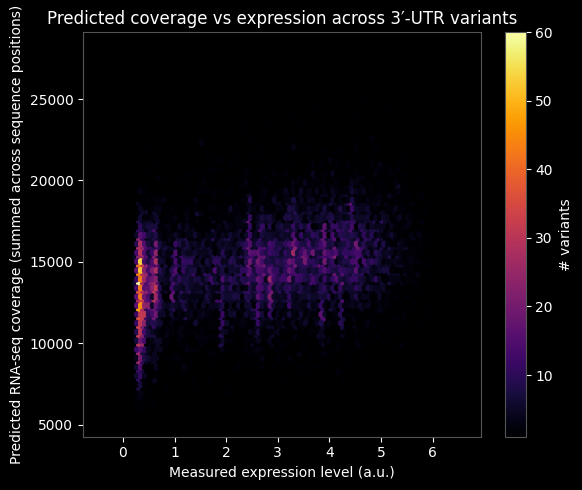

In [7]:
fig, ax = plot_hexbin_expression_vs_coverage(
    all_dfs,
    expression_col="expression_value",
    coverage_col="track_11_sum",
    gridsize=75,
    savepath=f"{output_dir}/coverage_vs_expression_hexbin.png",  # <-- file is saved
)
plt.show()

/tmp/ipykernel_3142/374015176.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


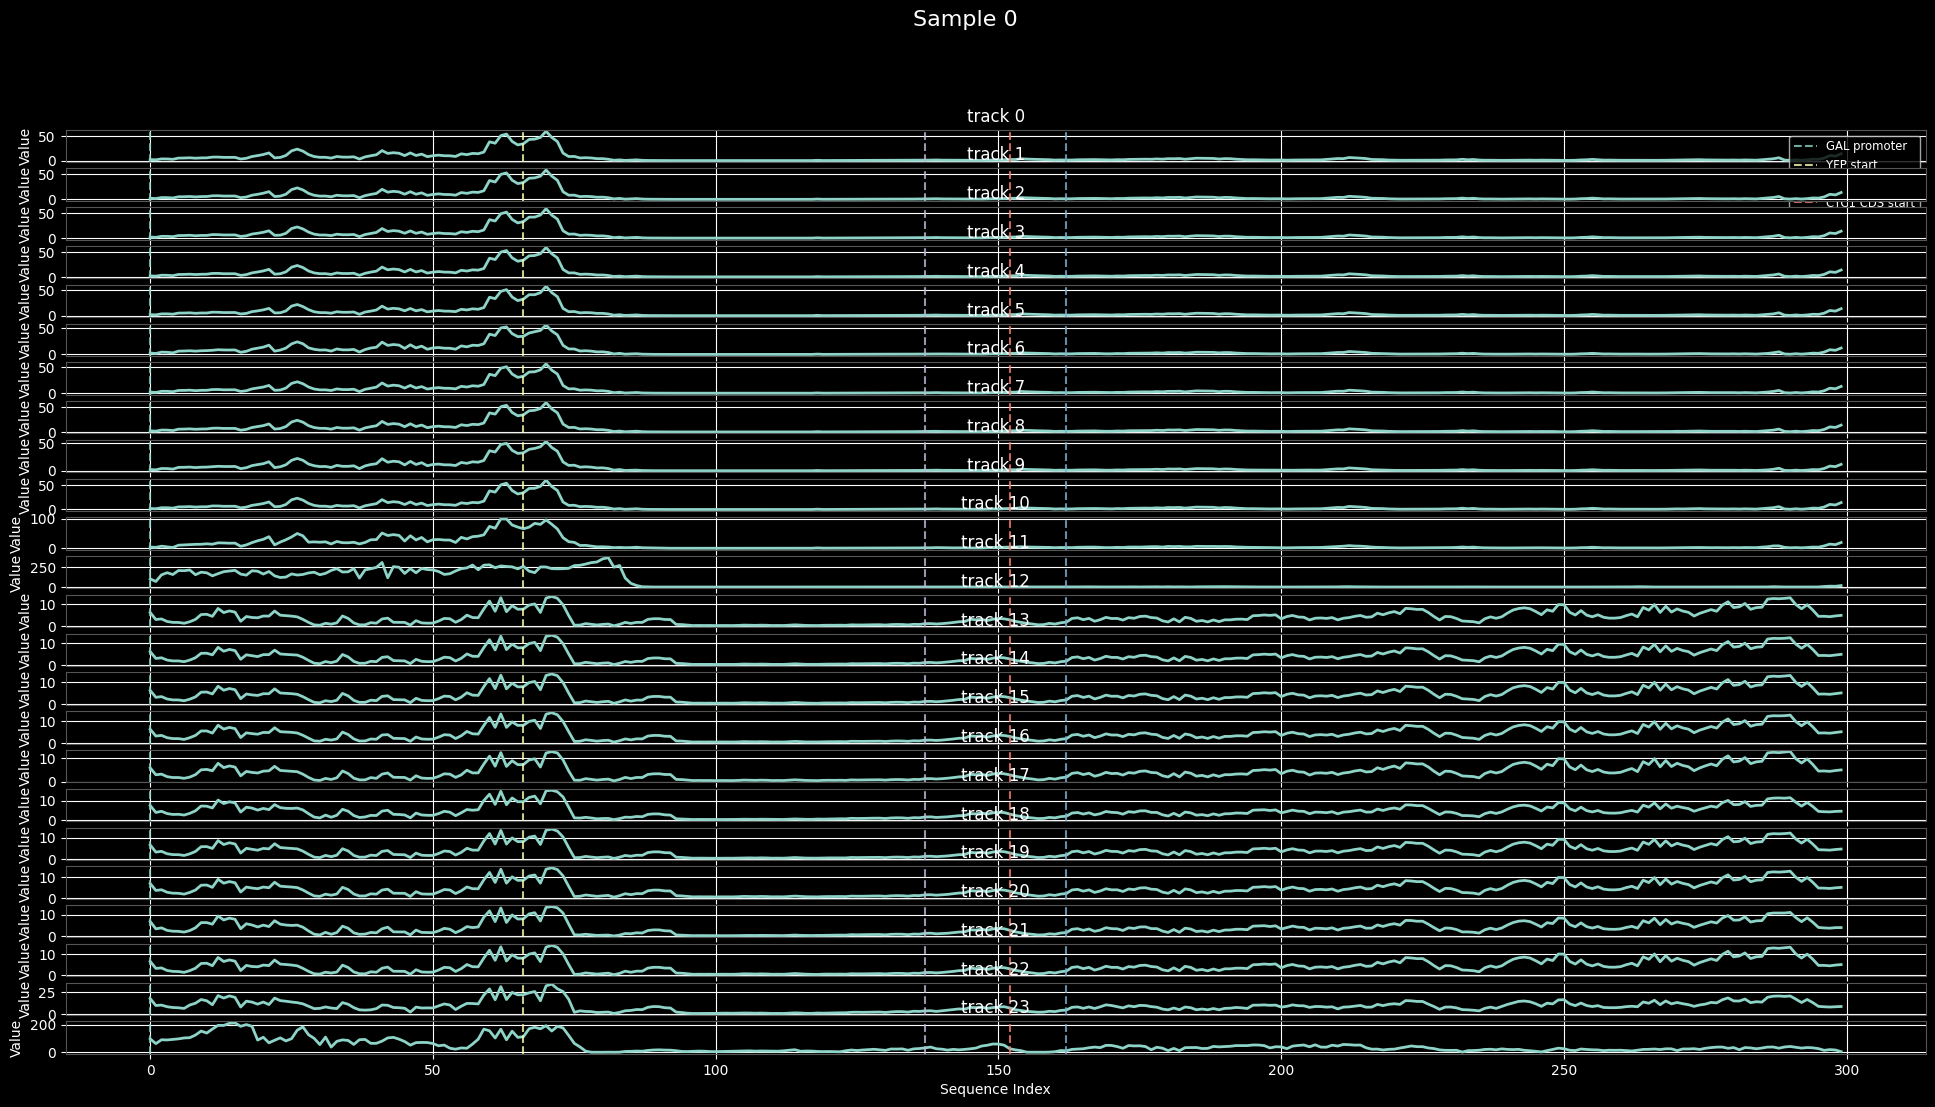

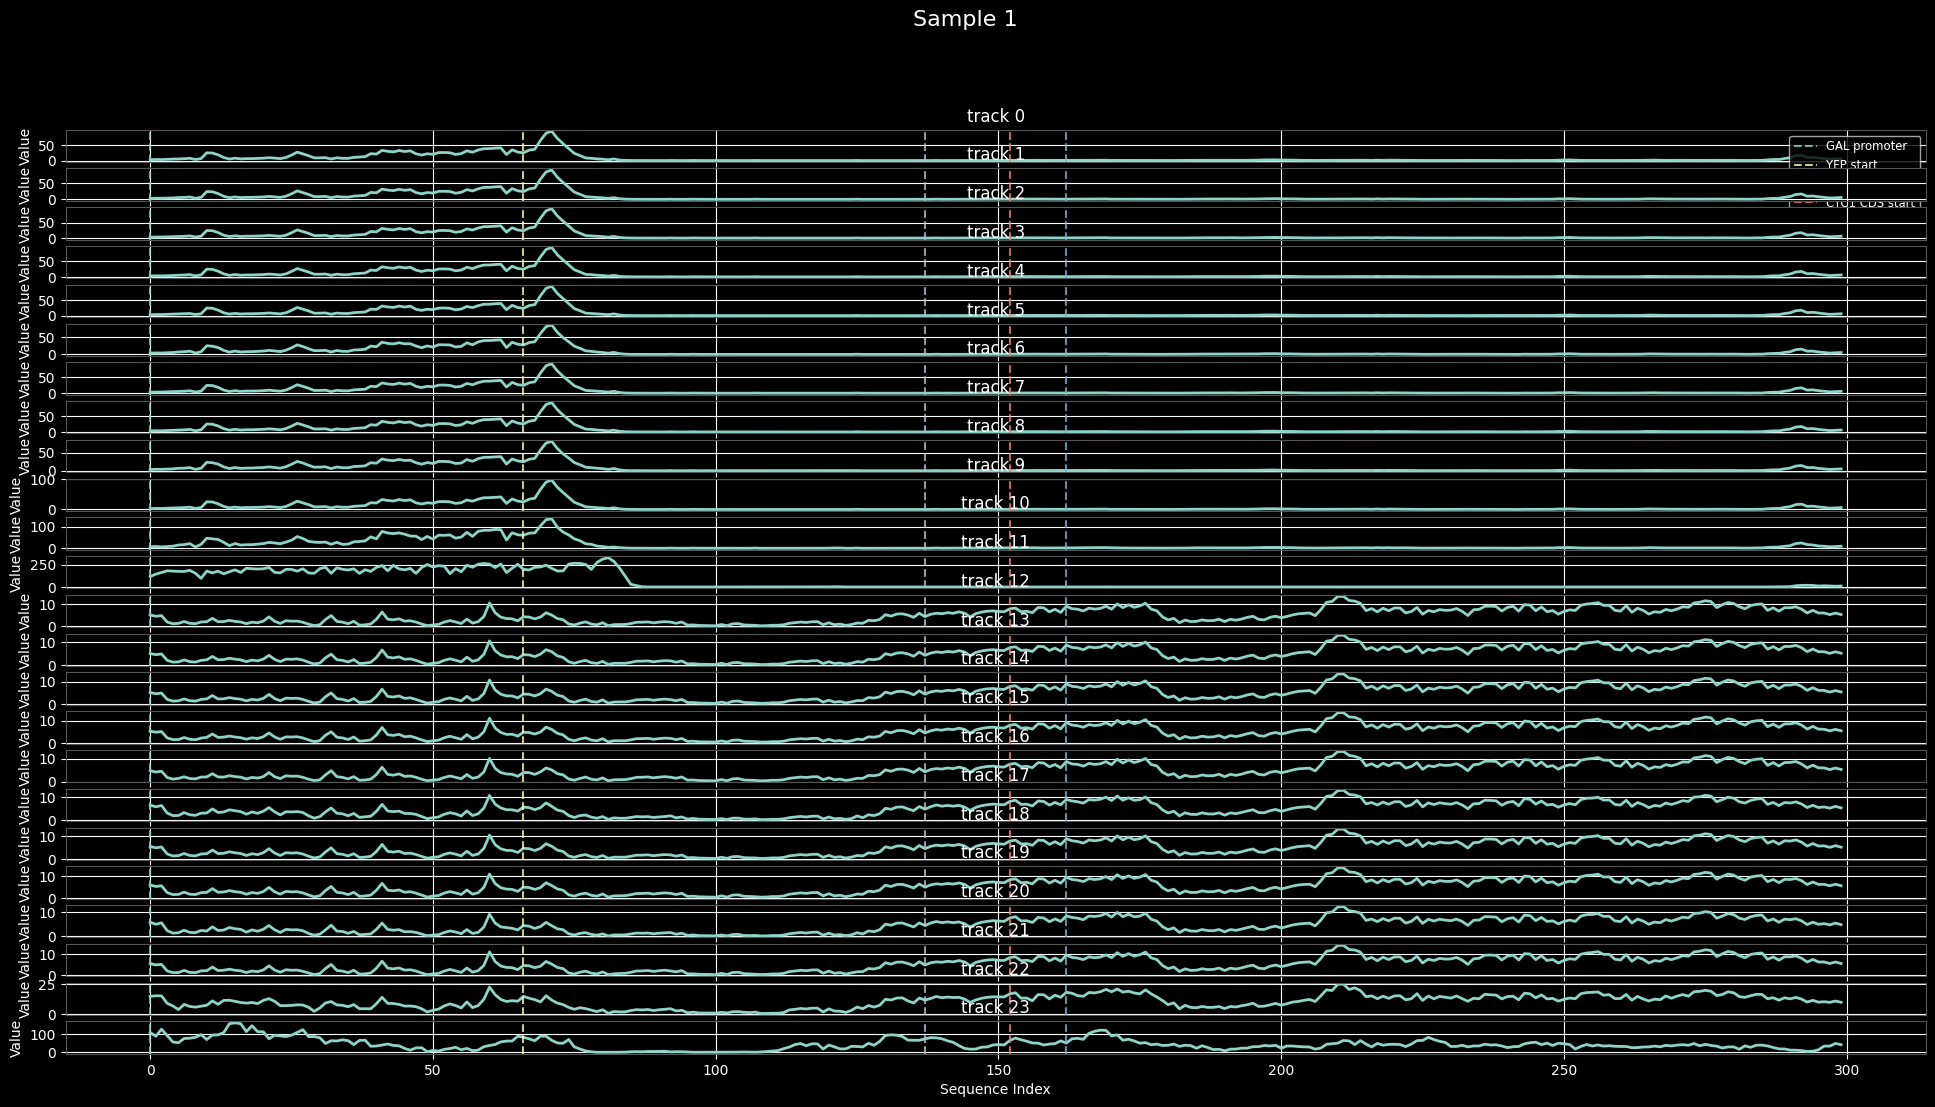

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_tensor_tracks(
    tensor,
    save_path=None,
    figsize=(5, 10),
    plot_titles=None,
    track_names=None,
    vertical_lines=None,
):
    """
    Creates batch plots from a PyTorch tensor, where each plot contains multiple
    subplots for different tracks.  Each vertical guide line is drawn in a
    different colour for easy visual separation.

    Args
    ----
    tensor : torch.Tensor
        Shape (batch_size, tracks, seq_len) on GPU.
    save_path : str | Path | None
        If given, figures are written to disk with suffix `_batch_<idx>.png`.
    figsize : tuple[int, int]
        Size of each figure in inches.
    plot_titles : list[str] | None
        Per-sample titles; default “Batch {i}”.
    track_names : list[str] | None
        Per-track titles; default “Track {j}”.
    vertical_lines : dict[str, int] | None
        Keys are labels, values are x positions (0-based index) to draw.
    """
    # ---- validate -----------------------------------------------------------
    if tensor.ndim != 3:
        raise ValueError(
            f"Expected tensor of shape (batch_size, tracks, seq_len), got {tensor.shape}"
        )

    # Move to CPU → NumPy for plotting
    tensor_np = tensor.detach().cpu().numpy()
    batch_size, num_tracks, seq_len = tensor_np.shape

    x_values = np.arange(seq_len)

    # ---- defaults -----------------------------------------------------------
    if plot_titles is None:
        plot_titles = [f"Batch {i}" for i in range(batch_size)]
    if track_names is None:
        track_names = [f"Track {j}" for j in range(num_tracks)]

    # Pre-compute a colour cycle for the vertical lines
    if vertical_lines:
        colour_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        vline_items = list(vertical_lines.items())  # preserve order
        vline_colours = {
            name: colour_cycle[i % len(colour_cycle)]
            for i, (name, _) in enumerate(vline_items)
        }

    # ---- iterate over samples ----------------------------------------------
    for batch_idx in range(batch_size):
        fig, axes = plt.subplots(
            nrows=num_tracks,  # one subplot per track
            figsize=figsize,
            sharex=True,
        )

        if num_tracks == 1:  # keep iterable
            axes = [axes]

        fig.suptitle(plot_titles[batch_idx], fontsize=16)

        # ---- per track ------------------------------------------------------
        for track_idx, ax in enumerate(axes):
            track_data = tensor_np[batch_idx, track_idx]
            ax.plot(x_values, track_data, linewidth=2)
            ax.set_title(track_names[track_idx])
            ax.grid(True)

            # vertical guide lines
            if vertical_lines:
                for name, position in vline_items:
                    if 0 <= position < seq_len:
                        ax.axvline(
                            x=position,
                            linestyle="--",
                            alpha=0.8,
                            color=vline_colours[name],
                            label=name,
                        )

                if track_idx == 0:
                    ax.legend(loc="upper right", fontsize="small")

            # axis labels
            if track_idx == num_tracks - 1:
                ax.set_xlabel("Sequence Index")
            ax.set_ylabel("Value")

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # ---- save or display ------------------------------------------------
        if save_path:
            fig.savefig(
                f"{save_path}_batch_{batch_idx}.png", dpi=300, bbox_inches="tight"
            )
            plt.close(fig)
        else:
            plt.show()


plot_tensor_tracks(
    prediction,
    figsize=(24, 12),
    plot_titles=[f"Sample {i}" for i in range(prediction.shape[0])],
    track_names=[f"track {i}" for i in range(prediction.shape[1])],
    vertical_lines={
        "GAL promoter": 0,
        "YFP start": 66,
        "insert start": 66 + 71,
        "CYC1 CDS start": 66 + 71 + 15,
        "CYC1 CDS end": 66 + 71 + 15 + 10,
    },
)

In [11]:
import pandas as pd

res = pd.read_csv("/home/workspace/clex/runs/2025-05-06_12-34-12_nanopore_full_debug/Shalem2015/all_samples_results.csv")

In [12]:
res

,sample_id,expression_value,track_0,track_1,track_2,track_3,track_4,track_5,track_6,track_7,...,track_152,track_153,track_154,track_155,track_156,track_157,track_158,track_159,track_160,track_161
0,sample_0,4.9528,5263.6743,5074.7373,5171.8765,5161.5710,4988.1846,5279.9946,5260.3790,5214.5967,...,1.117892,2047.8760,73.088390,6.511739,1762.7908,0.849273,22.399773,5.138070,1729.5076,3.542983
1,sample_1,4.8829,5203.5347,5016.6450,5112.2060,5102.3290,4931.1094,5219.7188,5200.1475,5155.2554,...,1.081157,2019.7946,69.056150,6.178664,1734.8970,0.813948,21.162373,4.987699,1705.2688,3.381336
2,sample_2,5.0143,5159.0180,4972.6465,5064.4023,5057.6304,4887.4277,5177.4844,5153.4414,5114.8477,...,1.416396,2035.3047,79.447754,7.396178,1720.3416,1.043427,25.200237,5.741905,1721.6749,4.129221
3,sample_3,5.2277,5222.8320,5034.7964,5129.4250,5120.8620,4947.9873,5244.5977,5219.2793,5177.9320,...,1.799955,2082.4690,94.451004,9.900305,1776.7078,1.432860,30.975536,7.268417,1766.8980,5.359536
4,sample_4,5.0864,5055.5703,4872.7110,4960.4854,4955.0913,4788.5107,5078.8516,5050.8190,5015.0874,...,1.737474,2018.3046,82.548020,8.563150,1695.5682,1.299905,27.382616,6.550024,1714.5332,4.743559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14167,sample_14167,5.6473,5612.9614,5414.4870,5526.0040,5505.7920,5321.0615,5642.1123,5624.6210,5552.8730,...,0.913768,2183.6170,78.686290,7.626831,1986.5999,0.793478,23.317661,5.490253,1865.6818,3.649512
14168,sample_14168,4.8618,5889.1230,5681.1630,5802.0776,5779.4775,5583.5310,5912.2944,5897.3540,5824.6455,...,1.570322,2321.5986,117.457180,13.713398,2117.5195,1.547387,37.593210,8.827343,1976.2749,6.467619
14169,sample_14169,4.9127,5761.5430,5555.9463,5671.1357,5654.0200,5460.5410,5780.3760,5761.6665,5703.5557,...,2.977206,2313.2664,150.018000,20.582993,2050.1640,2.921621,53.152092,12.710704,1961.2306,10.575163
14170,sample_14170,2.8552,5806.6880,5601.0290,5719.1710,5697.8190,5503.7090,5837.3525,5816.5900,5746.2590,...,2.606868,2341.6980,145.776200,20.929768,2126.1177,2.695749,50.988730,12.689075,2004.7898,10.111594


Figure written to /home/workspace/clex/runs/2025-05-06_12-34-12_nanopore_full_debug/Shalem2015/best_track_hexbin.png
Best correlated track was track_79


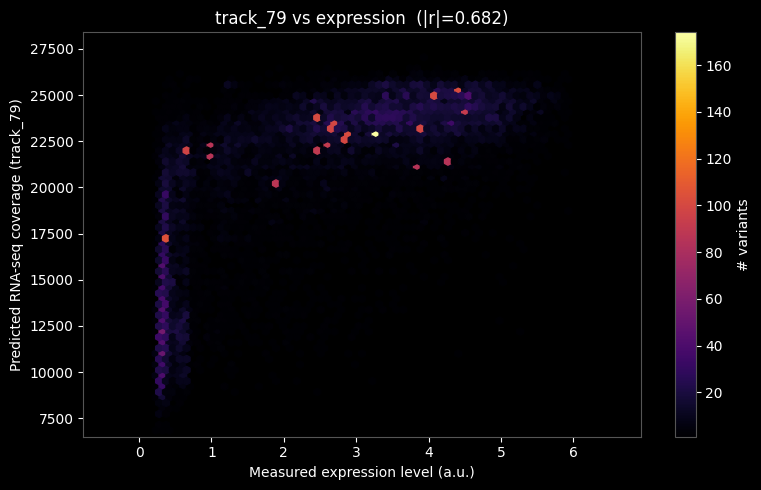

In [24]:
fig, ax, track = plot_hexbin_expression_vs_best_track(
    f"{base_path}/Shalem2015",
    savepath=f"{base_path}/Shalem2015/best_track_hexbin.png"
)
print(f"Best correlated track was {track}")


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_scatter_expression_vs_best_track(
    results_dir,                              # e.g. "…/Shalem2015"
    *,
    expression_col="expression_value",
    corr_file="track_expression_correlations.csv",
    results_file="all_samples_results.csv",
    use_first_half=True,                      # False → use second half of tracks
    figsize=(6, 5),
    xlabel="Measured expression level (a.u.)",
    ylabel_template="Predicted RNA-seq coverage ({track})",
    title_template="{track} vs expression  (|r|={rval:.3f})",
    marker="o",
    alpha=0.5,
    dpi=600,
    savepath=None,
):
    """
    Scatter plot of expression vs best-correlated track coverage.

    Parameters
    ----------
    results_dir : str or Path
        Directory containing the two CSVs from your inference step.
    use_first_half : bool
        If True, pick best track among the first half of the tracks.
    marker : str
        Matplotlib marker style.
    alpha : float
        Marker transparency.
    savepath : str or Path, optional
        If provided, figure is saved there.
    """
    # — load data —
    results_dir = Path(results_dir)
    corr_df     = pd.read_csv(results_dir / corr_file)
    results_df  = pd.read_csv(results_dir / results_file)

    # parse out numeric track index
    corr_df["track_idx"] = corr_df["track"].str.extract(r"(\d+)").astype(int)
    n_tracks  = corr_df["track_idx"].max() + 1
    half_mark = n_tracks // 2

    # select subset and best row
    mask      = corr_df["track_idx"] < half_mark if use_first_half else corr_df["track_idx"] >= half_mark
    subset_df = corr_df[mask]
    best_row  = subset_df.loc[subset_df["correlation_with_expression"].abs().idxmax()]

    best_track = best_row["track"]
    best_r     = best_row["correlation_with_expression"]

    # prepare data vectors
    x = results_df[expression_col].values
    y = results_df[best_track].values

    # labels/titles
    ylabel = ylabel_template.format(track=best_track)
    title  = title_template.format(track=best_track, rval=abs(best_r))

    # styling: dark background to match your original
    plt.style.use("dark_background")
    plt.rcParams["axes.edgecolor"] = "#555"

    # scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, marker=marker, alpha=alpha)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xlim(left=np.nanmin(x) - 1, right=np.nanmax(x) + 1)
    ax.set_ylim(bottom=np.nanmin(y) * 0.95, top=np.nanmax(y) * 1.05)

    fig.tight_layout()

    # optional save
    if savepath:
        savepath = Path(savepath)
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
        print(f"Saved scatter to {savepath.resolve()}")

    return fig, ax, best_track


Saved scatter to /home/workspace/clex/runs/2025-05-06_12-34-12_nanopore_full_debug/Shalem2015/scatter.png
Best track was track_79


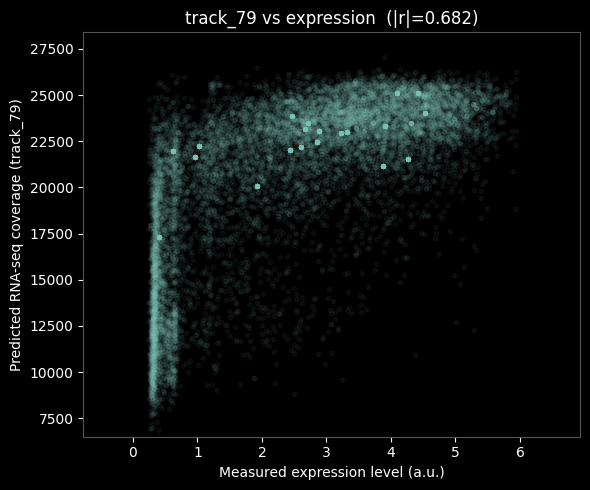

In [30]:
fig, ax, track = plot_scatter_expression_vs_best_track(
    f"{base_path}/Shalem2015",
    use_first_half=True,
    marker=".",
    alpha=0.05,
    savepath=f"{base_path}/Shalem2015/scatter.png"
)
print("Best track was", track)
